In [6]:
%matplotlib inline
from __future__ import division
import sys
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import sklearn.preprocessing as preprocessing
import sklearn.feature_extraction as feature_extraction
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, classification_report, roc_curve, auc,roc_auc_score
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV, ParameterSampler
from sklearn.kernel_approximation import RBFSampler
from scipy.stats.distributions import expon
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.pipeline import Pipeline, FeatureUnion
import unbalanced_dataset as ud
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold,StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from operator import itemgetter
from scipy.stats import randint as sp_randint
sns.set()
import matplotlib
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
matplotlib.rcParams['figure.figsize'] = (13.0, 13.0)
import time
class ItemSelector(BaseEstimator, TransformerMixin):
    """
    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
    def inverse_transform(self, X):
        return X
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

### Loaing Input Data from Pandas Dataframe

In [7]:
r = pd.read_csv('/Users/felipelolas/PycharmProjects/FracasoEscolarChile/DatasetsProcesados/SIMCE/ALU/SIMCE_GEO_2013-2014.csv', header=0, sep='|', decimal='.')
r = r.drop(r.columns[[0,29]],1)
r = r.fillna(-999, axis=0)
#a = r.groupby('RBD').DESERTA_ALU
#a = a[a > 150].index.values
a = r.COD_ENSE
a = a[a > 110].index.values
#r = r.loc[r['RBD'].isin(a)]
r = r.iloc[a]
#r = r.replace(to_replace=-999, value=np.nan)
#r = r.dropna()
cols = ['MRUN','COD_COM_ALU','NOM_COM_ALU','SIT_FIN_R','EDAD_ALU','CODINE11','LAT_MANZANA_ALU','LON_MANZANA_ALU','RIESGO_DESERCION_RBD','DIR_RBD','LAT_MANZANA_RBD','LON_MANZANA_RBD',
        'CONVIVENCIA_2M_RBD','CONVIVENCIA_4B_RBD','CONVIVENCIA_6B_RBD','CONVIVENCIA_8B_RBD','AUTOESTIMA_MOTIVACION_2M_RBD','AUTOESTIMA_MOTIVACION_4B_RBD','AUTOESTIMA_MOTIVACION_6B_RBD',
        'AUTOESTIMA_MOTIVACION_8B_RBD','PARTICIPACION_2M_RBD','PARTICIPACION_4B_RBD','PARTICIPACION_6B_RBD','PARTICIPACION_8B_RBD','IVE_MEDIA_RBD','IVE_BASICA_RBD',
        'PSU_PROM_2013_RBD','CPAD_DISP','DGV_RBD','NOM_RBD','NOM_COM_RBD','COD_COM_RBD','RBD','PROM_GRAL','ASISTENCIA','LET_CUR','CLASIFICACION_SEP_RBD','MAT_TOTAL_RBD', 'MAT_MEDIA_RBD', 'MAT_BASICA_RBD','PROF_INSP_H_MAT_RBD','PROF_ORI_H_MAT_RBD','TIPO_ESTAB_MAT_RBD','POB_FLOT_RBD','VACANTES_CUR_IN_RBD','CANT_DOC_RBD']
data = r.drop(cols,1)
data = data.drop(data.filter(like="IMPARTE").columns,1)
output_data = data[['ABANDONA_ALU','DESERTA_ALU','ABANDONA_2014_ALU']]
data = data.drop(['ABANDONA_ALU','DESERTA_ALU','ABANDONA_2014_ALU'],1)

## Preprocessing Pandas Dataframe

In [8]:
recall_1_scorer = make_scorer(recall_score, pos_label=1,average='binary')
recall_0_scorer = make_scorer(recall_score, pos_label=0,average='binary')
roc_curve_scorer = make_scorer(roc_curve,pos_label=1)
classes_names = ['Alumno no desertor(0)','Alumno desertor(1)']
ordinal_integer_cols = ['CANT_TRASLADOS_ALU','CANT_DELITOS_COM_ALU','CANT_CURSOS_RBD','CANT_DELITOS_MANZANA_RBD',
                   'CANT_DOC_M_RBD','CANT_DOC_F_RBD','PAGO_MATRICULA_RBD','PAGO_MENSUAL_RBD',
                   'SEL_SNED_RBD','BECAS_DISP_RBD','PROM_ALU_CUR_RBD','CANT_DELITOS_COM_RBD']
ordinal_float_data = data.loc[:, data.dtypes == float]
ordinal_data = pd.concat([ordinal_float_data, data[ordinal_integer_cols]],axis=1)
data = data.drop(ordinal_data.columns,1)
nominal_string_data = data.loc[:, data.dtypes == object]
nominal_data = data.loc[:, data.dtypes == int]
data = None
##Hacks para discretizar, no se puede usar en un Pipeline
LabelEncoder = {}
for i in nominal_string_data.columns:
    LabelEncoder[i] = preprocessing.LabelEncoder()
    nominal_string_data[i] = LabelEncoder[i].fit_transform(nominal_string_data[i])
nominal_data = pd.concat([nominal_data, nominal_string_data],axis=1)
data = pd.concat([ordinal_data, nominal_data],axis=1)
ordinalSelector = ItemSelector(ordinal_data.columns.values)
nominalSelector = ItemSelector(nominal_data.columns.values)
pipeline = Pipeline([
                ('Imputer', preprocessing.Imputer(-999, strategy='most_frequent')),
                ('MinMaxScaler',preprocessing.MinMaxScaler([-1,1])),
               # ('PCA', PCA()),
                ('RFC', RandomForestClassifier(class_weight='balanced'))
    ])
m = ['SOBRE_EDAD_ALU','PROM_GRAL_RANK','ASISTENCIA_RANK','EDU_SUP_M','EDU_SUP_P','GSE_MANZANA_ALU','GSE_MANZANA_RBD','CONVIVENCIA_PROM_RBD',
'PAGO_MATRICULA_RBD','PAGO_MENSUAL_RBD','SELECCION_RBD','AUTOESTIMA_MOTIVACION_PROM_RBD','PARTICIPACION_PROM_RBD','EDU_P','EDU_M']
X = data
y = output_data['DESERTA_ALU']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60)  
# specify parameters and distributions to sample from
param_dist = {"RFC__max_depth": sp_randint(1, 15),
              "RFC__min_samples_split": sp_randint(1, 15),
              "RFC__min_samples_leaf": sp_randint(1, 15),
              "RFC__n_estimators": sp_randint(10, 100),
              "RFC__bootstrap": [True, False],
              "RFC__criterion": ["gini", "entropy"],
             # "PCA__n_components" : sp_randint(1, 10)
             }

# run randomized search
n_iter_search = 3
#cv=StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.5)
cv=StratifiedKFold(y_train, n_folds=5, shuffle=True)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=n_iter_search,n_jobs=-1, scoring='roc_auc', cv=cv)
#recall_macro 89 84, 88 84
#recall 84 85, 83 84, 83 88
#recall_1_scorer 85 85, 85 85, 85 86
start = time.time()
print("Entrenando Modelo...")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.grid_scores_)
print("-------------------------------------------------")
print("Revisando Learning Error...")
y_pred = random_search.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred, target_names=classes_names))
print("-------------------------------------------------")
print("Realizando Prediccion...")
y_pred = random_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes_names))
print("-------------------------------------------------")

Entrenando Modelo...
RandomizedSearchCV took 126.42 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.916 (std: 0.007)
Parameters: {'RFC__min_samples_split': 7, 'RFC__bootstrap': True, 'RFC__n_estimators': 65, 'RFC__max_depth': 5, 'RFC__criterion': 'gini', 'RFC__min_samples_leaf': 8}

Model with rank: 2
Mean validation score: 0.913 (std: 0.007)
Parameters: {'RFC__min_samples_split': 3, 'RFC__bootstrap': False, 'RFC__n_estimators': 54, 'RFC__max_depth': 9, 'RFC__criterion': 'gini', 'RFC__min_samples_leaf': 8}

Model with rank: 3
Mean validation score: 0.902 (std: 0.008)
Parameters: {'RFC__min_samples_split': 3, 'RFC__bootstrap': False, 'RFC__n_estimators': 83, 'RFC__max_depth': 14, 'RFC__criterion': 'entropy', 'RFC__min_samples_leaf': 6}

-------------------------------------------------
Revisando Learning Error...
[[56465  4399]
 [  116   588]]
                       precision    recall  f1-score   support

Alumno no desertor(0)       1.00      0.

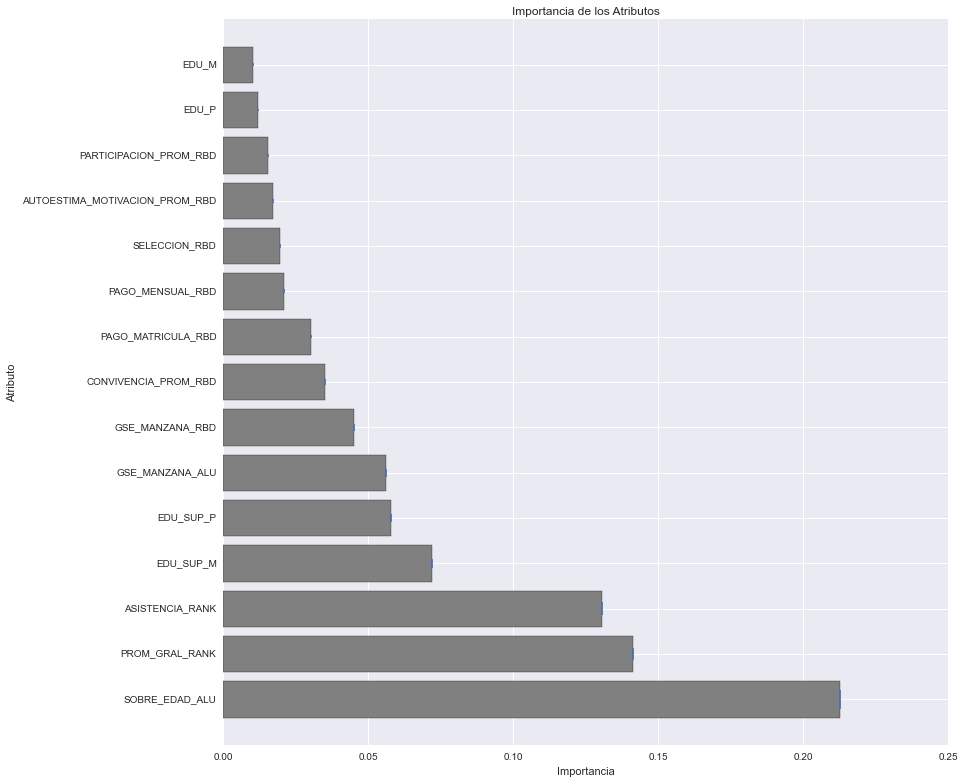

In [10]:
cantidad = data[m].shape[1]
importances = random_search.best_estimator_.steps[2][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in random_search.best_estimator_.steps[2][1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices = indices[0:cantidad]
# Print the feature ranking
#print("Feature ranking:")
#for f in range(cantidad):
    #print("%d. feature %s (%f)" % (f + 1, data.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Importancia de los Atributos")
plt.barh(range(importances[indices].shape[0]),importances[indices],
       color="gray",yerr=std[indices], align="center")
#plt.bar(range(importances[indices].shape[0]), importances[indices],
#       color="r", yerr=std[indices], align="center")
plt.yticks(range(importances[indices].shape[0]), data[m].columns.values, rotation='horizontal')
plt.ylim([-1, importances[indices].shape[0]])
plt.ylabel("Atributo")
plt.xlabel("Importancia")
plt.show()

In [ ]:
random_search.best_estimator_.predict_proba(X_test)[:,1].mean()

In [ ]:
random_search.best_estimator_.predict_proba(X_test)[:,0].mean()

